In [1]:
import pandas as pd
import numpy as np
import math
import mosek
import cvxpy as cp
import matplotlib.pyplot as plt
import time


names = locals()

In [2]:
#parameter
K=18
M=100

In [3]:
n_anchor = 20
n_sensor = 10

In [4]:

anchors = pd.read_excel('a0.xls', usecols = range(26), header=0, nrows=n_anchor) 
sensors = pd.read_excel('y0.xls', usecols = range(26), header=0, nrows=n_sensor)
dist = pd.read_excel('dist0.xls', usecols = range(n_sensor),nrows=n_anchor)
sensor = sensors.values
anchor = anchors.values
distance = dist.values

In [5]:
J = len(sensor[:,1])
I = len(anchor[:,1])

add variable $\hat{y_{j}}$

In [6]:
for j in range(J):
    exec('hat_y_{} = cp.Variable(2)'.format(j))
    

add variable $\lambda_{ij}$

In [7]:
for i in range(I):
    for j in range(J):
        exec('lam_{}_{} = cp.Variable(2)'.format(i, j))
        
# add variable v
v = cp.Variable((I,J))

In [8]:
x = cp.Variable(I, boolean=True)
mu = cp.Variable((I,J))
T = cp.Variable((I,J))

In [9]:
constraints = []

constraints.append(cp.sum(x) == K)

for i in range(I):
    for j in range(J):
        constraints.append(cp.norm(names.get('lam_{}_{}'.format(i,j))) <= mu[i][j])
        
constraints.append(v >= 0)

for i in range(I):
    for j in range(J):
        constraints.append(1 - distance[i][j]*mu[i][j] - v[i][j] == 0)

for j in range(J):
    sum_i_lam_ij = 0
    for i in range(I):
        sum_i_lam_ij += names.get('lam_{}_{}'.format(i,j))
    constraints.append(sum_i_lam_ij == 0)
    

for i in range(I):
    for j in range(J):
        constraints.append(cp.norm(anchor[i,:] - names.get('hat_y_{}'.format(j))) <=\
            distance[i][j]*(1 + T[i][j]) + M*(1-x[i]))


rhs = 0
for i in range(I):
    for j in range(J):
        rhs -= anchor[i,:]*names.get('lam_{}_{}'.format(i,j)) + distance[i][j]*mu[i][j]
constraints.append(cp.sum(T) == rhs)
        
for i in range(I):
    for j in range(J):
        constraints.append(mu[i][j] <= 100000*x[i])
        
constraints.append(T >= 0)
        
        
obj_exp = 0
for j in range(J):
    obj_exp += cp.norm(names.get('hat_y_' + str(j)) - sensor[j,:])
    



In [10]:
t = round(time.time())
obj = cp.Minimize(obj_exp)
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.MOSEK, verbose=True)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2452            
  Cones                  : 410             
  Scalar variables       : 2680            
  Matrix variables       : 0               
  Integer variables      : 20              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.06
Presolved problem: 1650 variables, 1022 constraints, 3420 non-zeros
Presolved problem: 0 general integer, 20 binary, 1630 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   1.0868864776e-13     NA          0.6   
0        1        1        0        5.5719792369e-01     1.0868864776e-13     100.00      1.0   
Cut generation started.
0        1        1        0   

0.5182924935672708

In [11]:
assert np.sum(x.value) == K

for i in range(I):
    for j in range(J):
        assert np.linalg.norm(names.get('lam_{}_{}'.format(i,j)).value) <= mu.value[i][j] + 1e-6
        
        
assert (v.value >= 0).all

for i in range(I):
    for j in range(J):
        assert abs(1 - distance[i][j]*mu.value[i][j] - v.value[i][j]) < 10e-6
        
for j in range(J):
    sum_i_lam_ij_value = 0
    for i in range(I):
        sum_i_lam_ij_value += names.get('lam_{}_{}'.format(i,j)).value
    assert (sum_i_lam_ij_value == 0).all
    
for i in range(I):
    for j in range(J):
        assert np.linalg.norm(anchor[i,:] - names.get('hat_y_{}'.format(j)).value) <=\
            distance[i][j]*(1+T.value[i][j]) + M*(1-x.value[i]) + 1e-6
        
#         assert np.linalg.norm(anchor[i,:] - sensor[j,:]) <=\
#             distance[i][j]*(1+T.value[i][j]) + M*(1-x.value[i]) + 1e-10
        
        

        
for i in range(I):
    for j in range(J):
        assert mu.value[i][j] <= 100000*x.value[i] + 1e-7
        

rhs_value = 0
for i in range(I):
    for j in range(J):
        rhs_value -= anchor[i,:].dot(names.get('lam_{}_{}'.format(i,j)).value) + distance[i][j]*mu.value[i][j]

assert abs(np.sum(T.value) - rhs_value) < 1e-6
        

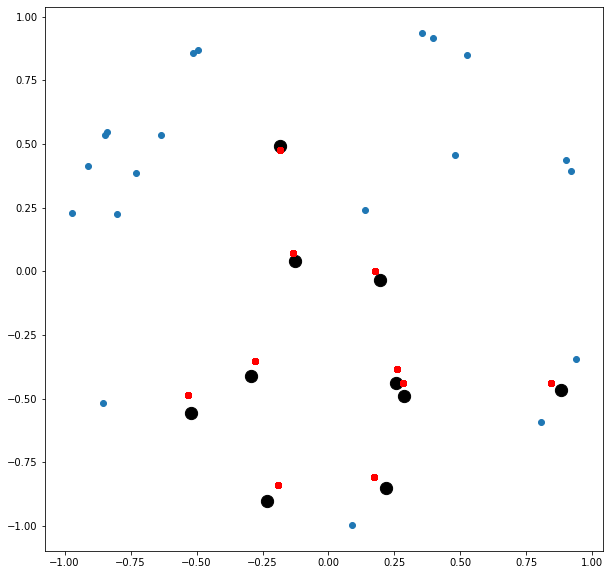

In [16]:

plt.figure(figsize=(10,10))
plt.scatter(x=anchor[:,0], y=anchor[:,1])
plt.scatter(x=sensor[:,0], y=sensor[:,1],c='k',s=150)

for i in range(I):
    for j in range(J):
        plt.scatter(x=names.get('hat_y_{}'.format(j)).value[0],
                    y=names.get('hat_y_{}'.format(j)).value[1],c='r')
plt.savefig('result/result_K{} M{} n_anchor{} n_sensor{} t{}.pdf'.format(K, M, n_anchor, n_sensor, t))